# Generate Realistic Human Face using GAN

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('-Put Input-DIR'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop


### Load the data and resize the iamges

In [17]:
#
PIC_DIR = f'Put-pic-dir'

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 10000/10000 [00:21<00:00, 470.14it/s]


In [18]:
#Image shape
images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


### Display first 25 images

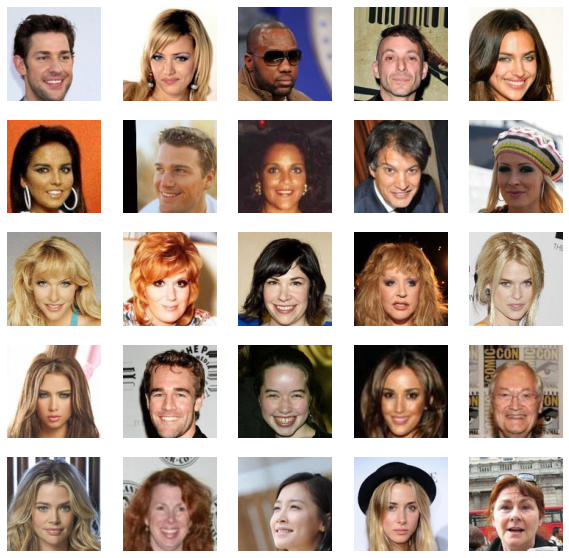

In [19]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [20]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [21]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [22]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

In [23]:
generator = create_generator()
generator.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 256)      

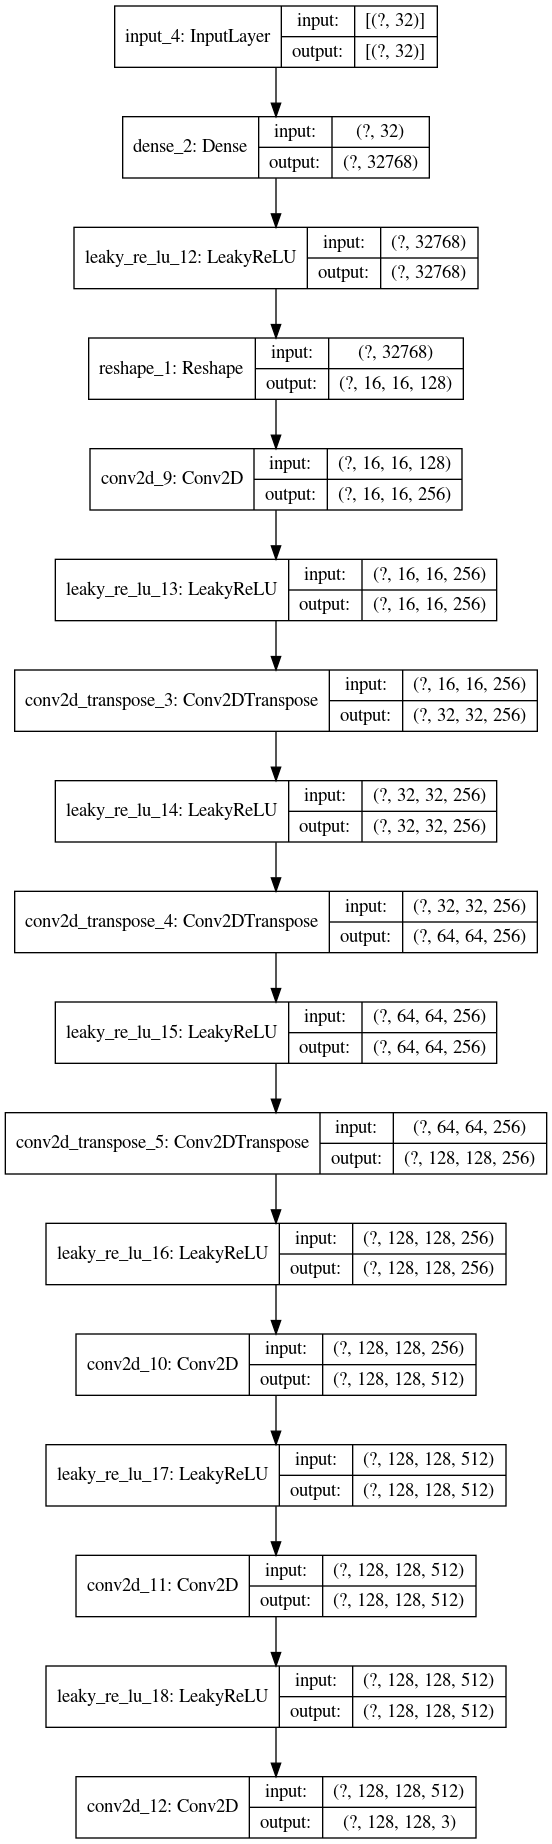

In [24]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [25]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 30, 30, 256)      

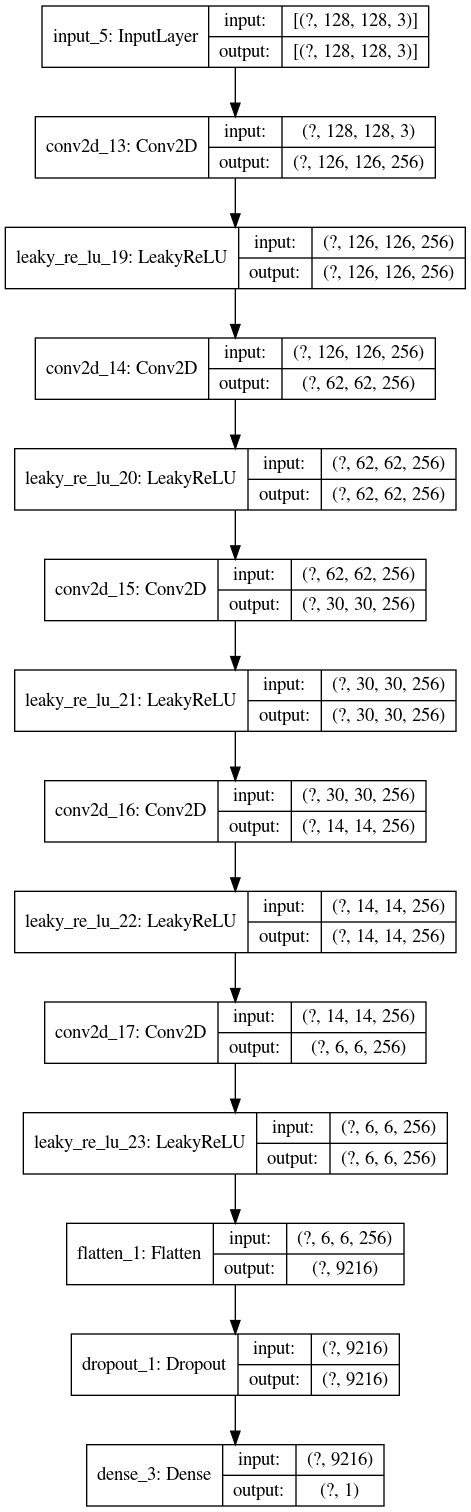

In [26]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [27]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [28]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [32]:
gan.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
functional_7 (Functional)    (None, 128, 128, 3)       14953987  
_________________________________________________________________
functional_9 (Functional)    (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [38]:
import time
iters = 15000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


50/15000: d_loss: 0.6669,  a_loss: 0.8859.  (1.2 sec)
100/15000: d_loss: 0.6763,  a_loss: 0.8942.  (1.1 sec)
150/15000: d_loss: 0.6369,  a_loss: 0.7525.  (1.1 sec)
200/15000: d_loss: 0.6715,  a_loss: 0.7687.  (1.1 sec)
250/15000: d_loss: 0.7249,  a_loss: 0.8495.  (1.1 sec)
300/15000: d_loss: 0.7371,  a_loss: 0.9171.  (1.2 sec)
350/15000: d_loss: 0.6970,  a_loss: 1.0709.  (1.2 sec)
400/15000: d_loss: 0.6551,  a_loss: 0.8128.  (1.2 sec)
450/15000: d_loss: 0.6271,  a_loss: 0.9188.  (1.2 sec)
500/15000: d_loss: 0.6816,  a_loss: 0.9816.  (1.2 sec)
550/15000: d_loss: 0.6245,  a_loss: 0.8990.  (1.2 sec)
600/15000: d_loss: 0.6554,  a_loss: 0.7865.  (1.2 sec)
650/15000: d_loss: 0.6379,  a_loss: 0.9310.  (1.2 sec)
700/15000: d_loss: 0.6003,  a_loss: 1.0782.  (1.2 sec)
750/15000: d_loss: 0.6635,  a_loss: 0.7920.  (1.3 sec)
800/15000: d_loss: 0.6874,  a_loss: 0.8958.  (1.2 sec)
850/15000: d_loss: 0.6663,  a_loss: 0.8491.  (1.2 sec)
900/15000: d_loss: 0.6532,  a_loss: 0.8485.  (1.2 sec)
950/15000: 

7400/15000: d_loss: 0.6414,  a_loss: 1.0408.  (1.2 sec)
7450/15000: d_loss: 0.6997,  a_loss: 0.7982.  (1.1 sec)
7500/15000: d_loss: 0.6981,  a_loss: 0.9733.  (1.2 sec)
7550/15000: d_loss: 0.6870,  a_loss: 0.8595.  (1.1 sec)
7600/15000: d_loss: 0.6568,  a_loss: 0.8720.  (1.1 sec)
7650/15000: d_loss: 0.7300,  a_loss: 0.8948.  (1.2 sec)
7700/15000: d_loss: 0.6492,  a_loss: 0.7688.  (1.2 sec)
7750/15000: d_loss: 0.6855,  a_loss: 0.8896.  (1.1 sec)
7800/15000: d_loss: 0.7356,  a_loss: 0.8639.  (1.2 sec)
7850/15000: d_loss: 0.6910,  a_loss: 0.8543.  (1.1 sec)
7900/15000: d_loss: 0.7372,  a_loss: 0.8737.  (1.2 sec)
7950/15000: d_loss: 0.7403,  a_loss: 0.8804.  (1.2 sec)
8000/15000: d_loss: 0.7175,  a_loss: 0.8129.  (1.1 sec)
8050/15000: d_loss: 0.7098,  a_loss: 0.6917.  (1.2 sec)
8100/15000: d_loss: 0.6554,  a_loss: 0.8397.  (1.1 sec)
8150/15000: d_loss: 0.6456,  a_loss: 0.8221.  (1.2 sec)
8200/15000: d_loss: 0.6587,  a_loss: 0.8412.  (1.1 sec)
8250/15000: d_loss: 0.7189,  a_loss: 0.9337.  (1

14650/15000: d_loss: 0.6341,  a_loss: 1.0714.  (1.1 sec)
14700/15000: d_loss: 0.6283,  a_loss: 0.7914.  (1.2 sec)
14750/15000: d_loss: 0.7053,  a_loss: 0.8124.  (1.1 sec)
14800/15000: d_loss: 0.6852,  a_loss: 1.0795.  (1.1 sec)
14850/15000: d_loss: 0.6856,  a_loss: 0.6660.  (1.2 sec)
14900/15000: d_loss: 0.6284,  a_loss: 1.0684.  (1.2 sec)
14950/15000: d_loss: 0.7086,  a_loss: 0.7761.  (1.2 sec)
15000/15000: d_loss: 0.6595,  a_loss: 0.8390.  (1.2 sec)


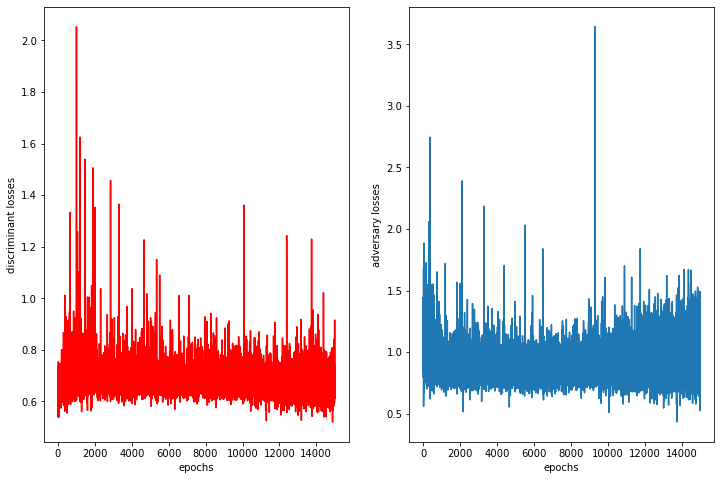

In [41]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [ ]:
import imageio
import shutilimages_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)